In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kritanjalijain/amazon-reviews -p /content

 99% 1.29G/1.29G [00:16<00:00, 63.3MB/s]
100% 1.29G/1.29G [00:16<00:00, 85.9MB/s]


In [ ]:
!unzip /content/amazon-reviews.zip -d /content/amazon-reviews

Archive:  /content/amazon-reviews.zip
  inflating: /content/amazon-reviews/amazon_review_polarity_csv.tgz  
  inflating: /content/amazon-reviews/test.csv  
  inflating: /content/amazon-reviews/train.csv  


In [ ]:
import pandas as pd
import re
import string
import collections
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/amazon-reviews/train.csv')
df_test = pd.read_csv('/content/amazon-reviews/test.csv')

In [ ]:
df_train.head()

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

In [ ]:
df_train.columns = ['label', 'title', 'text']
df_train.head()

,label,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [ ]:
df_test.columns = ['label', 'title', 'text']
df_test.head()

,label,title,text
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [ ]:
df_train = df_train.head(1000000)
df_test = df_test.head(100000)

In [ ]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

2    505677
1    494323
Name: label, dtype: int64
2    50579
1    49421
Name: label, dtype: int64


In [ ]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

In [ ]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [ ]:
df_train.head()

,label,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


In [ ]:
import numpy as np

# Assuming df_train is your training DataFrame
average_len = np.mean([len(item) for item in df_train['text']])
print("Average Length of Text in Training Dataset:", average_len)


Average Length of Text in Training Dataset: 435.926671


In [ ]:
max_len = int(average_len + 100)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

train_seq = tokenizer.texts_to_sequences(df_train['text'])
test_seq = tokenizer.texts_to_sequences(df_test['text'])


In [ ]:
train_pad = pad_sequences(train_seq , maxlen = max_len )
test_pad = pad_sequences(test_seq , maxlen = max_len )

In [ ]:
from tensorflow.keras.utils import to_categorical

train_label = to_categorical(df_train['label'])
test_label = to_categorical(df_test['label'])


In [ ]:
y_train = df_train['label'].values
y_train

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10_000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         12544     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])


In [ ]:
import numpy as np

train_seq_np = np.array(train_seq)

<ipython-input-26-9b9bb96260ab>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_seq_np = np.array(train_seq)


In [ ]:
print(type(train_seq), type(y_train))

<class 'list'> <class 'numpy.ndarray'>


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
train_seq_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')

train_seq_np = np.array(train_seq_padded)

y_train_np = np.array(y_train)

print(train_seq_np.shape, y_train_np.shape)


(1000000, 100) (1000000,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(train_seq_np, y_train_np, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/20
14063/14063 [==============================] - 4103s 291ms/step - loss: 0.2107 - accuracy: 0.9166 - val_loss: 0.1788 - val_accuracy: 0.9319
Epoch 2/20
14063/14063 [==============================] - 4130s 294ms/step - loss: 0.1598 - accuracy: 0.9398 - val_loss: 0.1614 - val_accuracy: 0.9384
Epoch 3/20
14063/14063 [==============================] - 4131s 294ms/step - loss: 0.1419 - accuracy: 0.9476 - val_loss: 0.1561 - val_accuracy: 0.9407
Epoch 4/20
14063/14063 [==============================] - 3933s 280ms/step - loss: 0.1292 - accuracy: 0.9530 - val_loss: 0.1733 - val_accuracy: 0.9370
Epoch 5/20
14063/14063 [==============================] - 3876s 276ms/step - loss: 0.1189 - accuracy: 0.9571 - val_loss: 0.1660 - val_accuracy: 0.9399
Epoch 6/20
14063/14063 [==============================] - 3936s 280ms/step - loss: 0.1102 - accuracy: 0.9608 - val_loss: 0.1708 - val_accuracy: 0.9353


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

y_test_np = np.array(df_test['label'])

loss, accuracy = model.evaluate(test_seq_np, y_test_np, verbose=0)

print('Accuracy: %f' % (accuracy * 100))

Accuracy: 93.915999


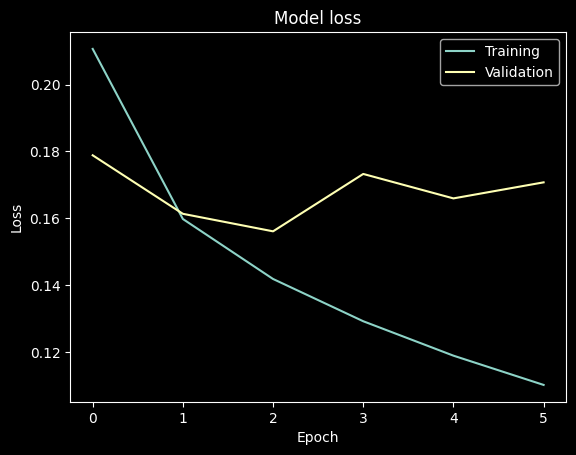

In [ ]:
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


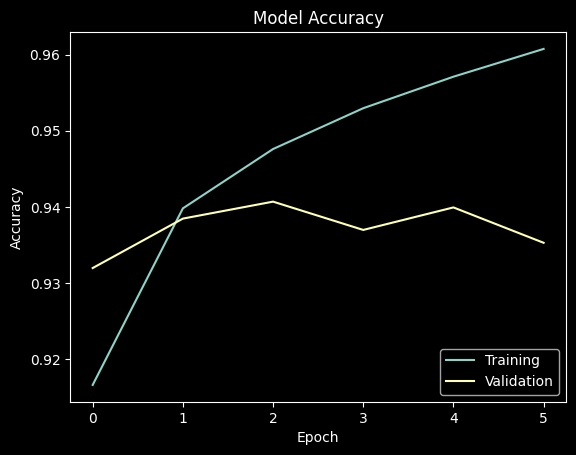

In [ ]:
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


3125/3125 [==============================] - 163s 51ms/step


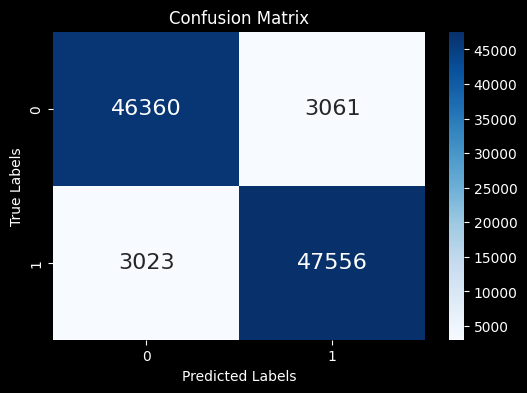

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

predictions = model.predict(test_seq_np)

predicted_labels = np.round(predictions)
true_labels = np.array(df_test['label'])

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

max_length = 100
test_seq_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

test_seq_np = np.array(test_seq_padded)

predictions = model.predict(test_seq_np)

predicted_labels = np.round(predictions)
true_labels = np.array(df_test['label'])

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

table = [
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1-score", f1]
]

print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

3125/3125 [==============================] - 159s 51ms/step
╒═══════════╤══════════╕
│ Metric    │    Value │
╞═══════════╪══════════╡
│ Accuracy  │ 0.93916  │
├───────────┼──────────┤
│ Precision │ 0.939526 │
├───────────┼──────────┤
│ Recall    │ 0.940232 │
├───────────┼──────────┤
│ F1-score  │ 0.939879 │
╘═══════════╧══════════╛


##END